# Unexpected subgraphs
---

Given an attributed graph $\mathcal{G}=(\mathcal{V, E, A})$, use **unexpectedness** $U=C_w - C$ to filter out attributed subgraphs $G_i=(V_i, E_i, A_i)$.

The unexpectedness of an attributed subgraph $G = (V, E, A)$ is defined as the sum of the unexpectedness of its structure $g$ and the unexpectedness of the set of attributes its nodes are sharing $A$
$$
U(G) = U(g) + U(A)
$$

**Subgraph structure** $g$   
* $U(g)=C_w(g) - C(g)$
* description complexity $C(g)$ is the number of bits to describe vertices and edges in graph  
$C(g) = \log(|V|) + \sum_{v \in V}\log{(b+1)} + \log(\binom{|V|}{k_v})$, with $b=\max_{v \in V}(\text{deg}(v))$ and $k$ is the number of non zero elements in a row  
* generation complexity $C_w(g)$ is the number of bits to describe a random graph sampled in original graph $\mathcal{G}$, with a given number of nodes and density

**Attributes** $A$
* $U(A)=C_w(A)-C(A)$
* description complexity $C(A)$ is the minimum description length for identifying the subgraph sharing characteristics $A \in \mathcal{A}$. It is defined using the number of occurences of each attribute $a \in A$, $\#a$. With this approach, a very common attribute such as '$\texttt{the}$' will yield a large complexity, whereas a non-common attribute will be considered as less complex.  
$C(A)=\sum_{a \in A}\log(\#a)$ 
* generation complexity $C_w(A)$ is the minimum description length to describe a set of $|A|$ elements from a vocabulary of size $\mathcal{A}$  
$C_w(A)=\log(\binom{|\mathcal{A}|}{|A|})$

In [603]:
from collections import defaultdict, Counter
from contextlib import redirect_stdout
from IPython.display import SVG
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import random
import seaborn as sns
from scipy import sparse, special

from sknetwork.clustering import get_modularity, KMeans, Louvain
from sknetwork.data import load_netset, from_edge_list
from sknetwork.embedding import Spectral, SVD
from sknetwork.gnn import GNNClassifier
from sknetwork.ranking import top_k
from sknetwork.topology import Triangles, Cliques, get_connected_components
from sknetwork.utils import get_degrees, get_membership, get_neighbors
from sknetwork.utils.kmeans import KMeansDense
from sknetwork.utils.check import get_probs
from sknetwork.visualization import svg_graph

from tfidf import TfIdf

In [604]:
wikivitals = load_netset('wikischools')

Parsing files...
Done.


In [605]:
wikivitals = load_netset('wikischools')
adjacency = wikivitals.adjacency
biadjacency = wikivitals.biadjacency
names = wikivitals.names
words = wikivitals.names_col
labels = wikivitals.labels

Parsing files...
Done.


In [606]:
print(adjacency.shape, adjacency.nnz)
print(biadjacency.shape, biadjacency.nnz)

(4403, 4403) 112834
(4403, 20527) 474138


In [ ]:
def extension(attrs, context):
    ext = set()
    if len(attrs) == 0:
        return np.arange(0, context.shape[0])
    for a in attrs:
        nodes = set(get_neighbors(context, node=a, transpose=True))
        if len(ext) == 0:
            ext.update(nodes)
        else:
            ext &= nodes
        if len(ext) == 0:
            break
    return np.asarray(list(ext))

def intention(nodes, context):
    intent = set()
    if len(nodes) == 0:
        return np.arange(0, context.shape[1])
    for n in nodes:
        attrs = set(get_neighbors(context, node=n))
        if len(intent) == 0:
            intent.update(attrs)
        else:
            intent &= attrs
        if len(attrs) == 0:
            break
    return np.asarray(list(intent))

In [6]:
def plot_distrib(values, ax, xlabel='degree', log=True, title=None, color='blue', alpha=1, label='Degree distribution'):
    counter = Counter(values)
    x, y = zip(*counter.items())
    ax.scatter(x, y, marker='+', color=color, alpha=alpha, label=label)
    ax.legend()
    ax.set_title(title)
    if log:
        ax.set_xscale('log')
        ax.set_xlabel(xlabel + ' (log)')
    else:
        ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency' + ' (log)')
    ax.set_yscale('log')
    
def mdl_graph(adjacency):
    n = adjacency.shape[0]

    # density
    #d = np.sum(adjacency) / (n * (n - 1))
    
    # nodes
    nodes_mdl = np.log2(n)
    
    # edges
    degrees = adjacency.dot(np.ones(n))
    max_degree = np.max(degrees)
    edges_mdl = (n + 1) * np.log2(max_degree + 1) + np.sum([np.log2(special.comb(n, deg)) for deg in degrees])

    if n == 1:
        return 1
    else:
        return (nodes_mdl + edges_mdl)

def entropy(prob):
    return prob * -np.log2(prob)

def desc_complexity(attrs):
    if isinstance(attrs, int):
        attrs = [attrs]
    prob = 1
    for attr in attrs:
        prob *= degrees[attr] / np.sum(degrees)
    entr = entropy(prob)
    return generation_complexity(biadjacency.shape[1], len(attrs)) * entr

def expand_list(l, idx, item):
    """If l[idx] does not exists, expand l with item."""
    try:
        l[idx] = item
    except IndexError:
        extents.append(item)    

In [13]:
%%time
complexity_gen_graphs = defaultdict(list)

for num_n in range(10 + 1)[1:15]:
    cpt = 0
    while cpt < 10:
        random_g = sparse.random(num_n, num_n, density=0.5).astype(bool).tocsr()
        if random_g is not None and random_g.shape[0] == num_n:
            mdl = mdl_graph(random_g)
            if num_n != 1:
                complexity_gen_graphs[num_n].append(mdl)
            else:
                # MDL of a graph of 1 node, is the MDL to describe this node
                complexity_gen_graphs[num_n].append(1)
            cpt += 1

CPU times: user 22.1 ms, sys: 4.69 ms, total: 26.8 ms
Wall time: 26.3 ms


In [8]:
G9 = sparse.csr_matrix(np.array([
    [0, 1, 1, 1, 1, 1, 0, 0],
    [1, 0, 1, 1, 1, 1, 0, 0],
    [1, 1, 0, 1, 1, 1, 0, 0],
    [1, 1, 1, 0, 1, 1, 0, 0],
    [1, 1, 1, 1, 0, 1, 1, 0],
    [1, 1, 1, 1, 1, 0, 1, 0],
    [0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 1, 0]
]))
X9 = sparse.csr_matrix(np.array([
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 1],
]))
names9 = np.array(range(G9.shape[0])).astype(str)
names_col9 = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g'])

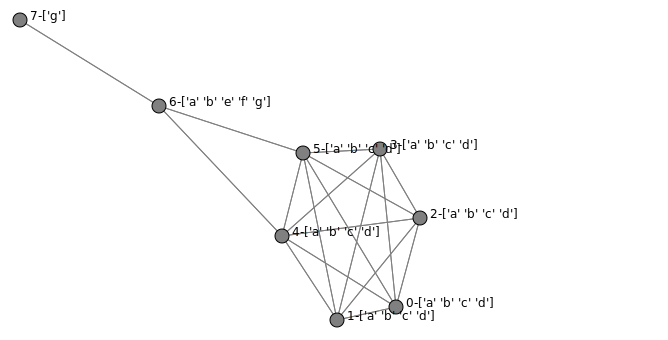

In [9]:
SVG(svg_graph(G9, names=[n + '-' + str(names_col9[x.indices]) for n, x in zip(names9, X9)]))

In [7]:
def is_cannonical(context, extents, intents, r, y):
    global r_new

    for k in range(len(intents[r])-1, -1, -1):
        for j in range(y, intents[r][k], -1):            
            for h in range(len(extents[r_new])):
                if context[extents[r_new][h], j] == 0:
                    h -= 1 # Necessary for next test in case last interaction of h for-loop returns False
                    break
            if h == len(extents[r_new]) - 1:
                return False
        y = intents[r][k] - 1

    for j in reversed(range(y, -1, -1)):
        for h in range(len(extents[r_new])):
            if context[extents[r_new][h], j] == 0:
                h -= 1 # Necessary for next test in case last interaction of h for-loop returns False
                break
        if h == len(extents[r_new]) - 1:
            return False
    
    return True

def extension(attrs, context):
    ext = set()
    if len(attrs) == 0:
        return np.arange(0, context.shape[0])
    for a in attrs:
        nodes = set(get_neighbors(context, node=a, transpose=True))
        if len(ext) == 0:
            ext.update(nodes)
        else:
            ext &= nodes
        if len(ext) == 0:
            break
    return np.asarray(list(ext))

def intention(nodes, context):
    intent = set()
    if len(nodes) == 0:
        return np.arange(0, context.shape[1])
    for n in nodes:
        attrs = set(get_neighbors(context, node=n))
        if len(intent) == 0:
            intent.update(attrs)
        else:
            intent &= attrs
        if len(attrs) == 0:
            break
    return np.asarray(list(intent))

def graph_unexpectedness(adjacency, gen_complexities):
    n = adjacency.shape[0]
    complexity_desc_g = mdl_graph(adjacency)
    complexity_gen_g = np.mean(gen_complexities.get(n))
    return complexity_gen_g - complexity_desc_g

def attr_unexpectedness(biadjacency, attributes, degrees):
    complexity_gen_a = np.log2(special.comb(biadjacency.shape[1], len(attributes)))
    complexity_desc_a = 0
    for a in attributes:
        complexity_desc_a += np.log2(degrees[a])
    return complexity_gen_a - complexity_desc_a

def pattern_unexpectedness(adjacency, biadjacency, gen_complexities, attributes, degrees):
    u_g = graph_unexpectedness(adjacency, gen_complexities)
    u_a = attr_unexpectedness(biadjacency, attributes, degrees)
    return u_g + u_a

In [8]:
class Pattern:
    def __init__(self, nodes, attrs):
        self.nodes = set(nodes)
        self.attrs = attrs
        
    def intent(self, nodes, context):
        intent = set()
        if len(self.nodes) == 0:
            return np.arange(0, context.shape[1])
        for n in self.nodes:
            attrs = set(get_neighbors(context, node=n))
            if len(intent) == 0:
                intent.update(attrs)
            else:
                intent &= attrs
            if len(intent) == 0:
                break
        return np.asarray(list(intent))
    
    def extent(self, attributes, context, adjacency):
        ext = set()
        if len(attributes) == 0:
            return np.arange(0, context.shape[0])
        for a in attributes:
            nodes = set(get_neighbors(context, node=a, transpose=True))
            if len(ext) == 0:
                ext.update(nodes)
            else:
                ext &= nodes
            if len(ext) == 0:
                break
        return np.asarray(list(ext))

    def minus(self, I):
        return list(set(I).difference(self.attrs))
    
    def copy(self):
        return Pattern(self.nodes.copy(), self.attrs.copy())
    
    def add(self, x):
        self.attrs.add(x)

In [506]:
import copy

def graph_enum(graph, context, degs, pattern, candidates=[], s=5, EL=set(), pattern_list=[], unexs=[], verbose=True):
    global depth
    
    if verbose:
        print(f'EL: {EL}, depth: {depth}')
    else:
        if len(EL) % 10 == 0:
            print(len(EL))
    q = pattern.attrs
    if verbose:
        print(f'Candidate pattern: ({len(pattern.nodes), pattern.attrs})')
    
    # Add pattern to list of valid patterns
    pattern_list.append(pattern)
    
    if verbose:
        print(f'Patterns: {[(len(x.nodes), x.attrs) for x in pattern_list]} - unexs: {unexs} - depth: {depth}')
    
    candidates = [x for x in pattern.minus(candidates) if not x in EL]
    
    pattern_bak = pattern.copy()
    for x in candidates:
        if verbose:
            print(f'Candidate: {x}')
        
        pattern_x = Pattern(pattern_bak.nodes.copy(), copy.deepcopy(pattern_bak.attrs))
        S = pattern_x.nodes.copy()
        
        # Add candidate to pattern
        pattern_x.add(x)
        
        # Support set (extent) of q_x
        subs = pattern_x.extent(pattern_x.attrs, context, adjacency)
        
        p_x = Pattern(subs, pattern_x.attrs)
        
        print(f'new extent: {p_x.nodes}')
        if len(p_x.nodes) >= s:
            
            # Get new intent
            p_x.attrs = set(p_x.intent(p_x.nodes, context))
            print(p_x.attrs)
            langs = p_x.attrs.intersection(EL)
            
            # reduce list of potential candidates to improve efficiency
            cands = list(set.union(*([set(get_neighbors(context, node=s)) for s in subs])))
            print(cands)
            
            if len(langs) == 0 and p_x.attrs != q:
                
                if len(unexs) == 0:
                    #unex = 0
                    unexs.append(0)
                #else:
                unex_g = graph_unexpectedness(adjacency[np.array(list(p_x.nodes)), :][:, np.array(list(p_x.nodes))], complexity_gen_graphs)
                unex_a = attr_unexpectedness(context, np.array(list(p_x.attrs)), degs)
                unex = unex_g + unex_a
                
                if verbose:
                    print(f'u-g {unex_g} - u-a:{unex_a} -u:{unex}')
                
                if verbose:
                    print(f'unexs: {unexs} - depth: {depth}')
                    print(f'compare unex={unex} and unexs[{depth}]={unexs[depth]}')
                if unex - unexs[depth] > 0:
                    if verbose:
                        print(f'  --> Pattern added to list')    
                    depth += 1
                    unexs.append(unex)
                    graph_enum(subs, context, degs, p_x, cands, s, EL.copy(), pattern_list, unexs, verbose)
                EL.add(x) 

    depth -= 1       
    #if depth >= 1:        
    #    del unexs[-(depth):]
    #else:
    #    del unexs[1:]
    unexs.pop(-1)
    if verbose:
        print(f'END FUNCTION')        
    return pattern_list

### Tf-Idf

In [548]:
dataset = load_netset('wikivitals')

adjacency = dataset.adjacency
orig_biadjacency = dataset.biadjacency
names = dataset.names
orig_words = dataset.names_col
labels = dataset.labels

orig_biadjacency

Parsing files...
Done.


<10011x37845 sparse matrix of type '<class 'numpy.int64'>'
	with 1363301 stored elements in Compressed Sparse Row format>

In [599]:
# tfidf
biadjacency = orig_biadjacency.copy()
tfidf_biadjacency = TfIdf().fit_transform(biadjacency)
tau = 0.01
for i, val in enumerate(tfidf_biadjacency.data):
    if val < tau:
        biadjacency.data[i] = 0
biadjacency.eliminate_zeros()

global depth
depth = 0

# Initialization
degs = get_degrees(biadjacency, transpose=True)

# Degree of attribute = # articles in which it appears
freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
index = np.flatnonzero((freq_attribute <= 10000) & (freq_attribute >= 5))

# Filter data with index
biadjacency = biadjacency[:, index]
words = orig_words[index]
freq_attribute = freq_attribute[index]
degs = degs[index]
print(f'Number of attributes after tfidf: {biadjacency.shape[1]}')

# Order attributes according to their ascending degree
# This allows to add first attributes that will generate bigger subgraphs
sort_index = np.argsort(freq_attribute)
sorted_degs = freq_attribute[sort_index]
filt_biadjacency = biadjacency[:, sort_index]
sorted_names_col = words[sort_index]

g = list(range(adjacency.shape[0]))
p = Pattern(g, set())
p.attrs = set(p.intent(p.nodes, filt_biadjacency))
candidates = list(range(filt_biadjacency.shape[1]))

Number of attributes after tfidf: 18310


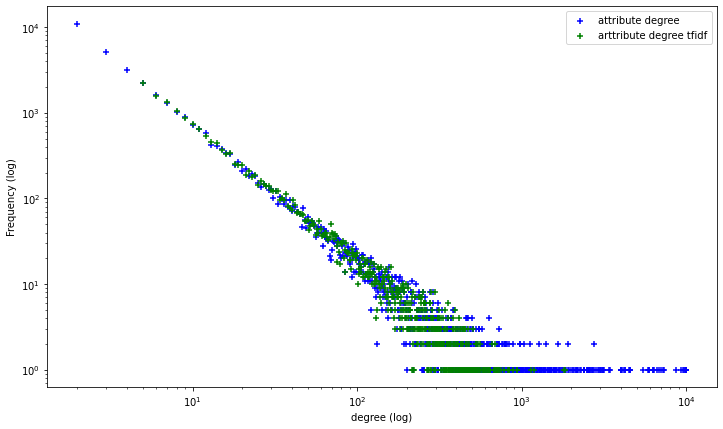

In [600]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
plot_distrib(get_degrees(orig_biadjacency, transpose=True), ax=ax, log=True, label='attribute degree')
plot_distrib(degs, ax=ax, log=True, label='arttribute degree tfidf', color='g')

In [601]:
print({i:n for i, n in enumerate(orig_words) if n in ['cmyk', 'RGB']})
print({i:n for i, n in enumerate(words) if n in ['cmyk', 'RGB']})

{14916: 'cmyk', 37430: 'RGB'}
{7294: 'cmyk', 18105: 'RGB'}


In [ ]:
%%time

"""with open('logs/log_wikischools_viard_u_tfidf.txt', 'w') as f:
    with redirect_stdout(f):
        pattern_list = graph_enum(g, filt_biadjacency, sorted_degs, p, candidates, s=5, EL=set(), pattern_list=[], unexs=[], verbose=True)"""
with open('logs/log_wikischools_viard_u_tfidf.txt', 'w') as f:
    with redirect_stdout(f):
        pattern_list = graph_enum(g, biadjacency, degs, p, candidates, s=5, EL=set(), pattern_list=[], unexs=[], verbose=True)

In [529]:
print(len(pattern_list))

1444


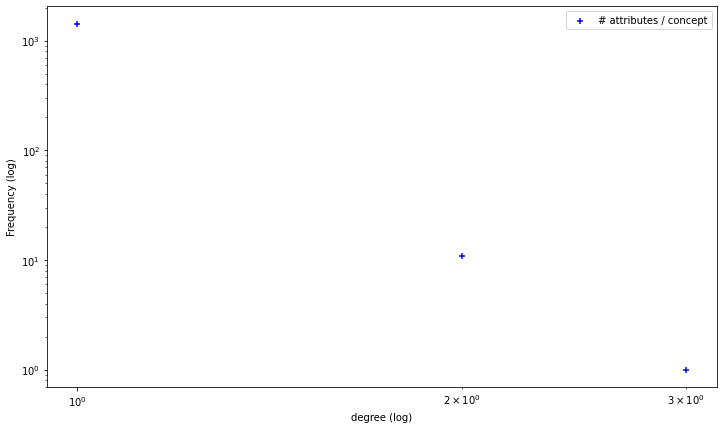

In [530]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
plot_distrib([len(x.attrs) for x in pattern_list], ax=ax, log=True, label='# attributes / concept')

In [479]:
idx = np.random.choice(biadjacency.shape[1])
name = words[idx]
name

'Church'

In [480]:
idx_orig = np.where(orig_words==name)[0][0]
print(f'First attribute: {orig_words[idx_orig]} - {idx_orig}')

neighbors_0 = get_neighbors(orig_biadjacency, node=idx_orig, transpose=True)
print(f'Appears in articles: {names[neighbors_0]}')

attr_neighbors = set(get_neighbors(orig_biadjacency, node=neighbors_0[0]))
for n in neighbors_0[1:2]:
    attrs_neighbor = get_neighbors(orig_biadjacency, node=n)
    attr_neighbors &= set(attrs_neighbor)
    
print(orig_words[list(attr_neighbors)])

First attribute: Church - 26234
Appears in articles: ['A. C. Bhaktivedanta Swami Prabhupada' 'Age of Enlightenment'
 'Aleksandr Solzhenitsyn' 'Alexander Nevsky' 'Alexandria'
 'Alexis of Russia' 'Algorithm' 'Ambrose' 'Anglicanism' 'Angola'
 'Anselm of Canterbury' 'Antigua and Barbuda'
 'António de Oliveira Salazar' 'Aphrodite' 'Aramaic' 'Aretha Franklin'
 'Aristotle' 'Arius' 'Armenia' 'Arminianism' 'Assyria'
 'Athanasius of Alexandria' 'Augustine of Hippo' 'Averroes' 'Baroque'
 'Baroque architecture' 'Baruch Spinoza' 'Basil of Caesarea' 'Bede'
 'Belgrade' 'Benedict of Nursia' 'Benito Juárez' 'Bible' 'Billy Graham'
 'Bonaventure' 'Boris I of Bulgaria' 'C. S. Lewis' 'Calvinism' 'Canberra'
 'Capetian dynasty' 'Cardinal Richelieu' 'Carnival' 'Catholic Church'
 'Catholicity' 'Charlemagne' 'Charles I of England' 'Christianity'
 'Circumcision' 'Classical music' 'Clement of Alexandria' 'Clovis I'
 'Cnut the Great' 'Colosseum' 'Columbia University' 'Computable function'
 'Confucianism' 'Constant

In [481]:
print(f'First attribute: {words[idx]} - {idx}')

neighbors_0 = get_neighbors(biadjacency, node=idx, transpose=True)
print(f'Appears in articles: {names[neighbors_0]}')

attr_neighbors = set(get_neighbors(biadjacency, node=neighbors_0[0]))
for n in neighbors_0[1:]:
    attrs_neighbor = get_neighbors(biadjacency, node=n)
    attr_neighbors &= set(attrs_neighbor)
    
print(words[list(attr_neighbors)])

First attribute: Church - 970
Appears in articles: ['Alexis of Russia' 'Ambrose' 'Anglicanism' 'Athanasius of Alexandria'
 'Augustine of Hippo' 'Basil of Caesarea' 'Catholic Church' 'Catholicity'
 'Coptic Orthodox Church of Alexandria' 'Eastern Catholic Churches'
 'Eastern Christianity' 'Eastern Orthodox Church' 'Ecumenism'
 'Ethiopian Orthodox Tewahedo Church' 'Greek Orthodox Church'
 'Gregory of Nazianzus' 'Holy See' 'Jerome' 'John Chrysostom'
 'John of the Cross' 'Nontrinitarianism' 'Old Church Slavonic'
 'Oriental Orthodox Churches' 'Patriarch Nikon of Moscow'
 'Pope Gregory VII' 'Protestantism' 'Purgatory' 'Puritans' 'Reformation'
 'Russian Orthodox Church' 'Saints Cyril and Methodius'
 'Theodora (wife of Justinian I)' 'Thomas Cranmer' 'Thomas More' 'Thomism'
 'Vulgate']
['Church']


In [356]:
{i:n for i, n in enumerate(names) if n in ['Ankara', 'Bosporus']}

{492: 'Ankara', 1184: 'Bosporus'}

In [357]:
biadjacency[492, :].indices

array([   6,   99,  958, 1488, 2393, 3390, 3407, 3716, 4174, 5124, 5332],
      dtype=int32)

In [358]:
biadjacency[1184, :].indices

array([ 128,  136,  194,  199,  493,  726,  958, 1086, 1584, 2001, 2248,
       2393, 2454, 2787, 2826, 2919, 3390, 3670, 3716, 3878, 4038, 4174,
       4419, 4433, 4656, 4815, 4956, 5022, 5036, 5128, 5302, 5472],
      dtype=int32)

In [359]:
set(biadjacency[492, :].indices).intersection(set(biadjacency[1184, :].indices))

{958, 2393, 3390, 3716, 4174}

In [227]:
G9 = sparse.csr_matrix(np.array([
    [0, 1, 1, 1, 1, 1, 0, 0],
    [1, 0, 1, 1, 1, 1, 0, 0],
    [1, 1, 0, 1, 1, 1, 0, 0],
    [1, 1, 1, 0, 1, 1, 0, 0],
    [1, 1, 1, 1, 0, 1, 1, 0],
    [1, 1, 1, 1, 1, 0, 1, 0],
    [0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 1, 0]
]))
X9 = sparse.csr_matrix(np.array([
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 1],
]))
names9 = np.array(range(G9.shape[0])).astype(str)
names_col9 = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g'])

In [228]:
global depth
depth = 0

# Initialization
adjacency = G9
biadjacency = X9 
degs = get_degrees(X9, transpose=True)

# Degree of attribute = # articles in which it appears
freq_attribute = get_degrees(X9.astype(bool), transpose=True)
index = np.flatnonzero((freq_attribute <= 1000) & (freq_attribute >= 0))

# Filter data with index
biadjacency = X9[:, index]
words = names_col9[index]
freq_attribute = freq_attribute[index]

g = list(range(G9.shape[0]))
p = Pattern(g, set())
p.attrs = set(p.intent(p.nodes, X9))
pattern_list = graph_enum(g, X9, p, s=1, EL=set(), pattern_list=[], unexs=[])

EL: set(), depth: 0
Candidate pattern: ((8, set()))
Patterns: [(8, set())] - unexs: [] - depth: 0
u-g 3.2820063402681185 - u-a:-1.2223924213364477 -u:2.059613918931671
unexs: [0] - depth: 0
compare unex=2.059613918931671 and unexs[0]=0
  --> Pattern added to list
EL: set(), depth: 1
Candidate pattern: ((7, {0, 1}))
Patterns: [(8, set()), (7, {0, 1})] - unexs: [0, 2.059613918931671] - depth: 1
u-g 6.785526874129822 - u-a:-5.655351828612555 -u:1.1301750455172668
unexs: [0, 2.059613918931671] - depth: 1
compare unex=1.1301750455172668 and unexs[1]=2.059613918931671
u-g 0.0 - u-a:-2.2223924213364477 -u:-2.2223924213364477
unexs: [0, 2.059613918931671] - depth: 1
compare unex=-2.2223924213364477 and unexs[1]=2.059613918931671
END FUNCTION
u-g -0.08170416594551 - u-a:1.8073549220576042 -u:1.7256507561120942
unexs: [0] - depth: 0
compare unex=1.7256507561120942 and unexs[0]=0
  --> Pattern added to list
EL: {0}, depth: 1
Candidate pattern: ((2, {6}))
Patterns: [(8, set()), (7, {0, 1}), (2, {6

In [229]:
for c in pattern_list:
    print((c.nodes), names_col9[list(c.attrs)])

{0, 1, 2, 3, 4, 5, 6, 7} []
{0, 1, 2, 3, 4, 5, 6} ['a' 'b']
{6, 7} ['g']


In [9]:
%%time
complexity_gen_graphs = defaultdict(list)

for num_n in range(adjacency.shape[0] + 1)[1:1000]:
    cpt = 0
    while cpt < 3:
        random_g = sparse.random(num_n, num_n, density=0.5).astype(bool).tocsr()
        if random_g is not None and random_g.shape[0] == num_n:
            mdl = mdl_graph(random_g)
            complexity_gen_graphs[num_n].append(mdl)
            cpt += 1

CPU times: user 1min 40s, sys: 3.87 s, total: 1min 44s
Wall time: 1min 44s


simpl


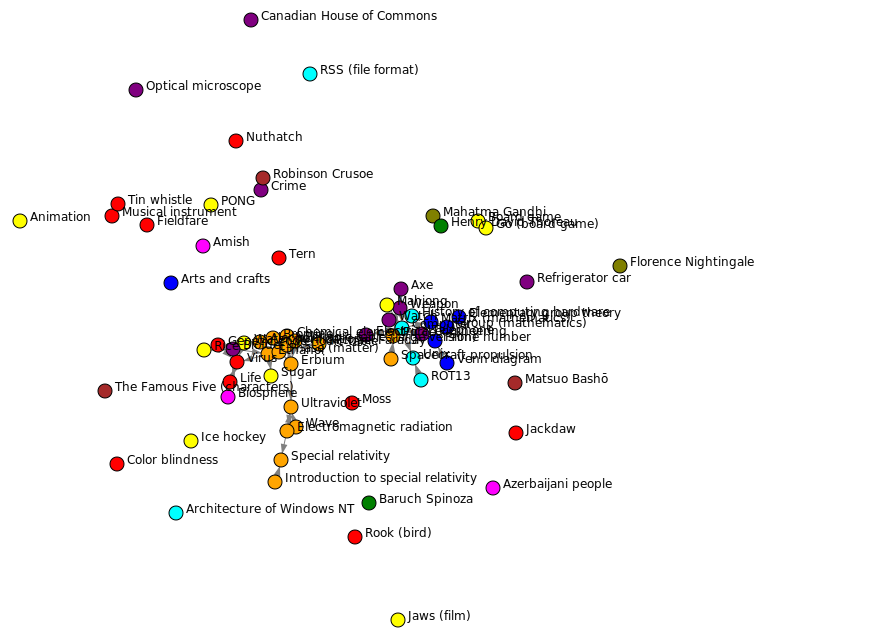

In [150]:
nodes = np.array([93, 301, 323, 440, 495, 532, 559, 586, 617, 750, 807, 952, 990, 1007, 1010, 1014, 1182, 1214, 1224, 1236, 1245, 1275, 1285, 1353, 1574, 1629, 1706, 1740, 1820, 1823, 1894, 1900, 1927, 2037, 2067, 2076, 2192, 2197, 2215, 2246, 2295, 2394, 2460, 2466, 2477, 2752, 2756, 2761, 2769, 2852, 2885, 2956, 3007, 3038, 3046, 3282, 3305, 3348, 3484, 3494, 3555, 3660, 3684, 3809, 3954, 4088, 4115, 4207, 4243, 4336])
print(words[0])
SVG(svg_graph(adjacency[nodes, :][:, nodes], labels=labels[nodes], names=names[nodes], width=600, height=600))

In [156]:
# Initialization
extents, intents = init_inclose(biadjacency)
degs = get_degrees(biadjacency, transpose=True)
global r_new
r_new = 0

# Degree of attribute = # articles in which it appears
freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
index = np.flatnonzero((freq_attribute <= 1000) & (freq_attribute >= 10))

# Filter data with index
biadjacency = biadjacency[:, index]
words = words[index]
freq_attribute = freq_attribute[index]

# Order attributes according to their ascending degree
# This allows to add first attributes that will generate bigger subgraphs
sort_index = np.argsort(freq_attribute)
sorted_degs = freq_attribute[sort_index]
filt_biadjacency = biadjacency[:, sort_index]
sorted_names_col = words[sort_index]

In [157]:
# Algorithm
with open('logs/log_wikivitals_closed_concepts_test.txt', 'w') as f:
    with redirect_stdout(f):
        concepts = in_close_new(adjacency, filt_biadjacency, extents, intents, r=0, y=0, 
                                min_support=5, max_support=1000,
                                degs=sorted_degs, unexs_g=[0], unexs_a=[0], unexs=[0], names_col=sorted_names_col)
        print()

print(len(concepts))

KeyboardInterrupt: 

In [80]:
for c in concepts:
    print(c[0], words[c[1]])

[0 1 2 3 4 5 6 7] []
[0, 1, 2, 3, 4, 5, 6] ['a' 'b']
[] []
[6, 7] ['g']


In [77]:
# Initialization
extents, intents = init_inclose(X9)
degs = get_degrees(X9, transpose=True)
global r_new
r_new = 0

# Degree of attribute = # articles in which it appears
freq_attribute = get_degrees(X9.astype(bool), transpose=True)
index = np.flatnonzero((freq_attribute <= 1000) & (freq_attribute >= 0))

# Filter data with index
biadjacency = X9[:, index]
words = names_col9[index]
freq_attribute = freq_attribute[index]

# Order attributes according to their ascending degree
# This allows to add first attributes that will generate bigger subgraphs
sort_index = np.argsort(freq_attribute)
sorted_degs = freq_attribute[sort_index]
filt_biadjacency = X9[:, sort_index]
sorted_names_col = words[sort_index]

# Algorithm
#concepts = in_close_new(G9, filt_biadjacency, extents, intents, r=0, y=0, degs=sorted_degs, unexs_g=[0], unexs_a=[0], unexs=[0], names_col=sorted_names_col)
concepts = in_close_new(G9, biadjacency, extents, intents, r=0, y=0, degs=degs, unexs_g=[0], unexs_a=[0], unexs=[0], names_col=names_col9)
for c in concepts:
    print(c[0], names_col9[c[1]])

NEW ITERATION 
 --------
extents: [0 1 2 3 4 5 6 7] - intents: []
  Candidate attr: a
  new extent: [0, 1, 2, 3, 4, 5, 6]
  Extent size DID change. IsCannonical: True
   New branch will be created, compute U of current concept.
  Intent: ['a']
  --> Enter recursion...
  U difference; 0
      **Unexpectedness: [0, 0]
NEW ITERATION 
 --------
extents: [0, 1, 2, 3, 4, 5, 6] - intents: ['a']
  Candidate attr: b
  new extent: [0, 1, 2, 3, 4, 5, 6]
  Extent size did not change -> attribute b is added to intent.
ELSE r: 1 - r_new: 2
Unexs: [0, 0, 0]
[array([0, 1, 2, 3, 4, 5, 6, 7]), [0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6]] [[], [0, 1]]
extents[r_new]: [0, 1, 2, 3, 4, 5, 6] - intents[r]: ['a' 'b']
  U(G): 3.754601512360047
  U(A): -1.2223924213364477
  U: 2.5322090910235993
Unexs: [0, 2.5322090910235993, 0]
r: 1 - r_new: 2
  U difference; 2.5322090910235993
extents: [0, 1, 2, 3, 4, 5, 6] - intents: ['a' 'b']
  Candidate attr: c
  new extent: [0, 1, 2, 3, 4, 5]
  Extent size DID change. Is

In [37]:
for c in concepts:
    print(c[0], sorted_names_col[c[1]])

[0 1 2 3 4 5 6 7] []
[0, 1, 2, 3, 4, 5, 6] ['e' 'f']
[0, 1, 2, 3, 4, 5] ['e' 'f' 'g' 'c']
[6] ['e' 'f' 'd' 'a' 'b']
[6, 7] ['b']


In [36]:
for c in concepts:
    print(c[0], names_col9[c[1]])

[0 1 2 3 4 5 6 7] []
[0, 1, 2, 3, 4, 5, 6] ['a' 'b']
[0, 1, 2, 3, 4, 5] ['a' 'b' 'c' 'd']
[6] ['a' 'b' 'e' 'f' 'g']
[6, 7] ['g']


In [183]:
def in_close(adjacency, context, extents, intents, unexs, unexs_g, r, y, degs, gain, support_obj, names_col, verbose):
    
    #support_obj = support_obj

    support_attr = 15
    support_common_remaining_attr = 1
    delta = 0
    
    global gain_unex
    # --------------------
    
    global r_new
    r_new = r_new + 1
    attributes = np.arange(0, context.shape[1])
    
    for n_iter, j in enumerate(attributes[y:]):
        
        try:
            extents[r_new] = []
            unexs[r_new] = 0
            unexs_g[r_new] = 0
        except IndexError:
            extents.append([])
            unexs.append(0)
            unexs_g.append(0)

        # Form a new extent by adding extension of attribute j to current concept extent
        extension_j = get_neighbors(context, node=j, transpose=True)
        new_extent = np.array(list(set(extents[r]).intersection(set(extension_j))))
        extents[r_new] = new_extent
        new_extent_size = len(new_extent)
        
        # Verify that intention: prune recursion if the current none of the current extent neighbor have common attribute anymore
        len_closure = 0
        if len(new_extent > 0):
            all_neighbs = set(get_neighbors(context, node=new_extent[0]))
            for o in new_extent[1:]:
                neighbs = get_neighbors(context, node=o)
                all_neighbs &= set(neighbs)
            len_closure = len(all_neighbs)
        
        if len_closure >= support_common_remaining_attr:
            #if verbose:
            #    print(f'closure of {new_extent} --> size of closure = {len_closure}>{support_obj}')
            
            
            if new_extent_size >= support_obj:
                if verbose:
                    print(f'n_iter:{n_iter} - extents: {extents[r]} - intents: {intents[r]}')
                    print(f'  Candidate attr: {j} {names_col[j]}')
                    print(f'  new extent: {new_extent}')

                #if new_extent_size < len(extents[r]):
                # Graph unexpectedness
                g_r_new = adjacency[new_extent][:, new_extent]
                complexity_desc_g = mdl_graph(g_r_new)
                complexity_gen_g = np.mean(complexity_gen_graphs.get(new_extent_size))
                unex_g = complexity_gen_g - complexity_desc_g
                unexs_g.append(unex_g)
                if verbose:
                    print(f'  U(G)={unex_g} (cw={complexity_gen_g} - c={complexity_desc_g})')

                new_intent = np.array(list(sorted(set(intents[r]).union(set([j])))))
                new_intent_size = len(new_intent)            

                if new_intent_size <= support_attr:

                    # Attributes unexpectedness
                    complexity_gen_a = np.log2(special.comb(context.shape[1], new_intent_size))
                    complexity_desc_a = 0
                    for a in new_intent:
                        complexity_desc_a += np.log2(degs[a])
                    unex_a = complexity_gen_a - complexity_desc_a
                    if verbose:
                        print(f'  U(A)={unex_a} (cw={complexity_gen_a} - c={complexity_desc_a})')

                    # Total Unexpectedness
                    unex = unex_g + unex_a
                    if verbose:
                        print(f'  U: {unex}')
                    unexs[r_new] = unex

                    if verbose:
                        print(f'  U[r_new]={unex} - U[r]={unexs[r]}  = {unex - unexs[r]}')

                    gain_unex.append(unex - unexs[r])
                    if verbose:
                        print(f'  gain unex: {gain_unex}')
                        print(f'  Gain unex diff: {np.abs(gain_unex[-2]-gain_unex[-1])}')

                    if new_extent_size == len(extents[r]):

                        #if unex - unexs[r] > 4 and r >=0 and np.abs(gain_unex[-2]-gain_unex[-1])>1:
                        #if (len(intents[r]) == 0) or ((unex - unexs[r] > 0) and (np.abs(gain_unex[-2] - gain_unex[-1])) > delta):
                        intents[r] = np.array(list(sorted(set(intents[r]).union(set([j])))))
                        extents[r] = extents[r_new]
                        unexs_g[r] = unex_g
                        unexs[r] = unex
                        if verbose:
                            print(f'  Attribute {j}-{sorted_names_col[j]} added')
                        #else:
                        #    if verbose:
                        #        print(f'  unex - unexs[r] > 0 : {(unex - unexs[r] > 0)}')
                        #        print(f'  (gain_unex[-2] - gain_unex[-1]) > delta : {(gain_unex[-2] - gain_unex[-1]) > delta}')
                        #        print(f'  len(intents[r]) == 0 : {len(intents[r]) == 0}')
                        #        print(f'  --> Stop branch recursion. ')
                        #       print('\n')

                            #del gain_unex[(r_new-r):]
                        #        if len(intents[r]) > 1:
                        #            del gain_unex[-(len(intents[r]))+1:]
                        #        else:
                        #            del gain_unex[-(len(intents[r])):]

                        #    return [*zip(extents, intents)]

                    else:
                        #if unex - unexs[r] > 4 and r >=0 and np.abs(gain_unex[-2]-gain_unex[-1])>1:
                        if (len(intents[r]) == 0) or (unex - unexs[r] > 0):

                            try:
                                intents[r_new] = []
                            except IndexError:
                                intents.append([])

                            intents[r_new] = np.array(list(sorted(set(intents[r]).union(set([j])))))
                            if verbose:
                                print('  recursive call')
                            in_close(adjacency, context, extents, intents, unexs, unexs_g, r=r_new, y=j+1, degs=degs, gain=gain_unex, 
                                     support_obj=support_obj, names_col=names_col, verbose=verbose)
                        else:
                            if verbose:
                                print(f'  Do not go into recursion. Try next candidate attribute. ')
                                print()
                            gain_unex.pop(-1)
                else:
                    if verbose:
                        print(f'Max number of attributes reached.')
                        print('\n')
                    return [*zip(extents, intents)]

            #else:
            #    if verbose:
            #        print(f'  New extent size >= support? : {new_extent_size >= support_obj}')
            
        #else:
            #if verbose:
                #    print(f'closure of {new_extent} --> no need to verify all attributes')
    if verbose:
        print('\n')
        

    if len(intents[r]) > 1:
        del gain_unex[-(len(intents[r]))+1:]
    else:
        del gain_unex[-(len(intents[r])):]
    return [*zip(extents, intents)]

In [184]:
def run_algorithm(G, X, names_col, n_objects_min, n_objects_max, out_name):
    # In-close initialization
    V = np.arange(0, X.shape[0])

    extents, intents, unexs, unexs_g = [], [], [], []
    extents_init = V
    intents_init = []
    unexs.append(0)
    unexs_g.append(0)
    extents.append(extents_init)
    intents.append(intents_init)
    
    global r_new
    r_new = 0
    global gain_unex
    gain_unex = []
    gain_unex.append(0)
    
    # Degree of attribute = # articles in which it appears
    freq_attribute = get_degrees(X.astype(bool), transpose=True)
    index = np.flatnonzero((freq_attribute <= n_objects_max) & (freq_attribute >= n_objects_min))
    
    # Filter data with index
    biadjacency = X[:, index]
    words = names_col[index]
    freq_attribute = freq_attribute[index]
    
    # Order attributes according to their ascending degree
    # This allows to add first attributes that will generate bigger subgraphs
    sort_index = np.argsort(freq_attribute)
    sorted_degs = freq_attribute[sort_index]
    filt_biadjacency = X[:, sort_index]
    sorted_names_col = words[sort_index]
    print(sorted_names_col)
    
    with open(f'logs/{out_name}.txt', 'w') as f:
        with redirect_stdout(f):
            result = in_close(G, filt_biadjacency, extents, intents, unexs, unexs_g, r=0, y=0, 
                              degs=sorted_degs, gain=gain_unex, support_obj=n_objects_min, names_col=sorted_names_col, verbose=True)
            print()
            
    return result, sorted_names_col

In [84]:
def run_algorithm_comeg(G, X, names_col, n_objects_min, n_objects_max, out_name):
    # In-close initialization
    V = np.arange(0, X.shape[0])

    extents, intents, unexs, unexs_g = [], [], [], []
    extents_init = V
    intents_init = []
    unexs.append(0)
    unexs_g.append(0)
    extents.append(extents_init)
    intents.append(intents_init)
    
    global r_new
    r_new = 0
    global gain_unex
    gain_unex = []
    gain_unex.append(0)
    
    # Degree of attribute = # articles in which it appears
    freq_attribute = get_degrees(X.astype(bool), transpose=True)
    index = np.flatnonzero((freq_attribute <= n_objects_max) & (freq_attribute >= n_objects_min))
    
    # Filter data with index
    biadjacency = X[:, index]
    words = names_col[index]
    freq_attribute = freq_attribute[index]
    
    # Order attributes according to their ascending degree
    # This allows to add first attributes that will generate bigger subgraphs
    sort_index = np.argsort(freq_attribute)
    sorted_degs = freq_attribute[sort_index]
    filt_biadjacency = X[:, sort_index]
    sorted_names_col = words[sort_index]
    
    with open(f'logs/{out_name}.txt', 'w') as f:
        with redirect_stdout(f):
            result = comeg(G, filt_biadjacency, extents, intents, unexs, unexs_g, r=0, y=0, 
                              degs=sorted_degs, gain=gain_unex, support_obj=n_objects_min, names_col=sorted_names_col, verbose=True)
            print()
    return result, sorted_names_col

## Custom graphs

In [8]:
%%time
complexity_gen_graphs = defaultdict(list)

for num_n in range(10 + 1)[1:15]:
    cpt = 0
    while cpt < 10:
        random_g = sparse.random(num_n, num_n, density=0.5).astype(bool).tocsr()
        if random_g is not None and random_g.shape[0] == num_n:
            mdl = mdl_graph(random_g)
            if num_n != 1:
                complexity_gen_graphs[num_n].append(mdl)
            else:
                # MDL of a graph of 1 node, is the MDL to describe this node
                complexity_gen_graphs[num_n].append(1)
            cpt += 1

CPU times: user 13.7 ms, sys: 2.04 ms, total: 15.7 ms
Wall time: 14.3 ms


### Custom1

In [13]:
G1 = sparse.csr_matrix(np.array([
    [0, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 1],
    [0, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1, 0],
]))
X1 = sparse.csr_matrix(np.array([
    [1, 0],
    [1, 0],
    [1, 0],
    [0, 1],
    [0, 1],
    [0, 1],
]))
names1 = np.array(['0', '1', '2', '3', '4', '5'])
names_col1 = np.array(['a', 'b'])

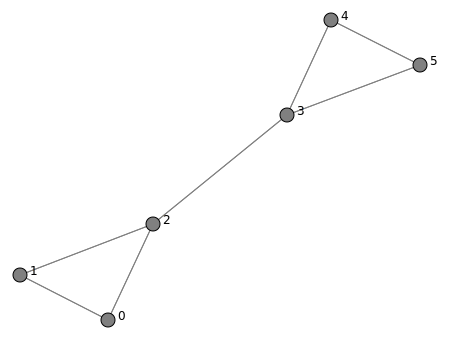

In [14]:
SVG(svg_graph(G1, names=names1))

In [15]:
%%time
result, sorted_names_col = run_algorithm(G1, X1, names_col1, 1, 1000, 'log_custom1')

['a' 'b']
CPU times: user 1.82 ms, sys: 1.37 ms, total: 3.19 ms
Wall time: 3.07 ms


In [16]:
for c in result:
    print(c[0], sorted_names_col[c[1]])

[0 1 2 3 4 5] []
[0 1 2] ['a']
[3 4 5] ['b']


### Custom2

In [17]:
G2 = sparse.identity(6).tocsr()
X2 = sparse.identity(6).tocsr()
names2 = np.array(['0', '1', '2', '3', '4', '5'])
names_col2 = np.array(['a', 'b', 'c', 'd', 'e', 'f'])

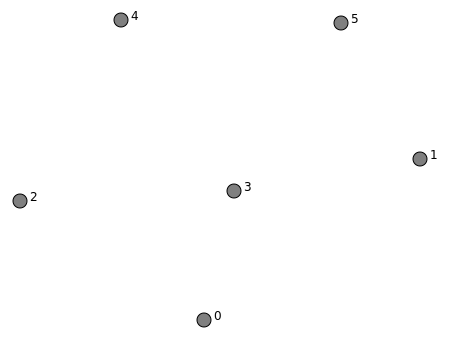

In [18]:
SVG(svg_graph(G2, names=names2))

In [19]:
%%time
result, sorted_names_col = run_algorithm(G2, X2, names_col2, 1, 1000, 'log_custom2')

['a' 'b' 'c' 'd' 'e' 'f']
CPU times: user 3.45 ms, sys: 1.23 ms, total: 4.68 ms
Wall time: 3.97 ms


In [20]:
for c in result:
    print(c[0], sorted_names_col[c[1]])

[0 1 2 3 4 5] []
[0] ['a']
[1] ['b']
[2] ['c']
[3] ['d']
[4] ['e']
[5] ['f']


### Custom3

In [21]:
G3 = sparse.csr_matrix(np.array([
    [0, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 1],
    [0, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1, 0],
]))
X3 = sparse.csr_matrix(np.array([
    [1, 0, 1, 0, 0],
    [1, 0, 0, 1, 0],
    [1, 0, 0, 0, 1],
    [0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0],
]))
names3 = np.array(['0', '1', '2', '3', '4', '5'])
names_col3 = np.array(['a', 'b', 'c', 'd', 'e'])

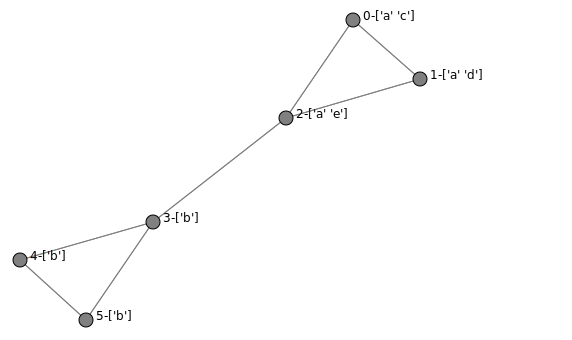

In [22]:
SVG(svg_graph(G3, names=[n + '-' + str(names_col3[x.indices]) for n, x in zip(names3, X3)]))

In [23]:
%%time
result, sorted_names_col = run_algorithm(G3, X3, names_col3, 1, 1000, 'log_custom3')

['c' 'd' 'e' 'a' 'b']
CPU times: user 3.69 ms, sys: 1.49 ms, total: 5.18 ms
Wall time: 4.73 ms


In [24]:
for c in result:
    print(c[0], sorted_names_col[c[1]])

[0 1 2 3 4 5] []
[0] ['c']
[1] ['d']
[2] ['e']
[0 1 2] ['a']
[3 4 5] ['b']


Exemple d'itération de l'algo:
- `'c'` est l'attribut candidat $\rightarrow$ le sous-graphe $G_c$ = {0} est filtré $\rightarrow$ ce graphe est inattendu (comparé à l'ensemble vide) $\rightarrow$ on continue la récursion
- `'a'` est attribut candidat $\rightarrow$ le sous-graphe $G_{[c,a]}$ = {0} est filtré (inchangé) $\rightarrow$ ce graphe est moins inattendu que le précédent $\rightarrow$ l'attribut candidat n'est pas ajouté et on arrête la récursion **En effet, `'a'` est partagé par 3 noeuds et n'apporte pas de assez surprise par rapport à l'itération précédente**

### Custom4  

1 article which is the concatenation of 2 articles from different communities, citing other articles

In [25]:
G4 = sparse.csr_matrix(np.array([
    [0, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 1],
    [0, 0, 0, 0, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 0]
]))
X4 = sparse.csr_matrix(np.array([
    [1, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 0, 0],
    [1, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 1, 0, 0, 1],
]))
names4 = np.array(range(G4.shape[0])).astype(str)
names_col4 = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])

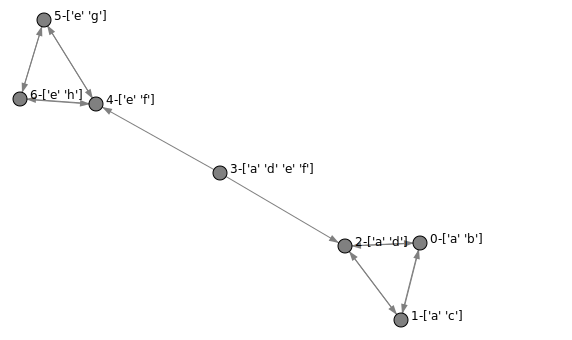

In [26]:
SVG(svg_graph(G4, names=[n + '-' + str(names_col4[x.indices]) for n, x in zip(names4, X4)]))

In [27]:
%%time
result, sorted_names_col = run_algorithm(G4, X4, names_col4, 1, 1000, 'log_custom4')

['b' 'c' 'g' 'h' 'd' 'f' 'a' 'e']
CPU times: user 5.85 ms, sys: 1.18 ms, total: 7.03 ms
Wall time: 8.17 ms


In [28]:
for c in result:
    print(c[0], sorted_names_col[c[1]])

[0 1 2 3 4 5 6] []
[0] ['b']
[1] ['c']
[5] ['g']
[6] ['h']
[2 3] ['d']
[3 4] ['f']
[0 1 2 3] ['a']
[3 4 5 6] ['e']


* pros : 
     - les noeuds `5` et `6`, et `0` et `1` ne sont décrits que par leurs attributs discriminants
     - idem pour les concepts `[2, 3]` et `[3, 4]`
     - pas de concept avec un seul noeud si ce noeud est déjà dans d'autres concepts plus gr-ands
* cons: 
    - pas de concepts avec les noeuds `[2, 3, 4]` $\rightarrow$ on pourrait voir un concept inattendu qui regroupe ces noeuds ? mais comment prendre en compte la clôture vide ?
    - concept avec le noeud `3` et les attributs `['d', 'f']`, i.e discriminants ?

### Custom5  

1 article which is the concatenation of 2 articles from different communities, without citing other articles

In [29]:
G5 = sparse.csr_matrix(np.array([
    [0, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1],
    [0, 0, 0, 0, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 0]
]))
X5 = sparse.csr_matrix(np.array([
    [1, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 0, 0],
    [1, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 1, 0, 0, 1],
]))
names5 = np.array(range(G5.shape[0])).astype(str)
names_col5 = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])

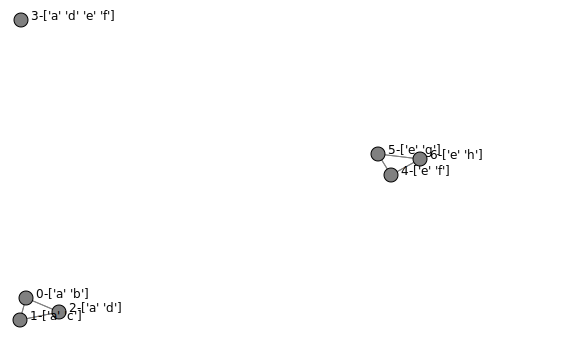

In [30]:
SVG(svg_graph(G5, names=[n + '-' + str(names_col5[x.indices]) for n, x in zip(names5, X5)]))

In [31]:
%%time
result, sorted_names_col = run_algorithm(G5, X5, names_col5, 1, 1000, 'log_custom5')

['b' 'c' 'g' 'h' 'd' 'f' 'a' 'e']
CPU times: user 5.98 ms, sys: 1.45 ms, total: 7.44 ms
Wall time: 6.3 ms


In [32]:
for c in result:
    print(c[0], sorted_names_col[c[1]])

[0 1 2 3 4 5 6] []
[0] ['b']
[1] ['c']
[5] ['g']
[6] ['h']
[2 3] ['d']
[3 4] ['f']
[0 1 2 3] ['a']
[3 4 5 6] ['e']


* pros:
    - pas de concept avec un seul noeud si ce noeud est déjà dans d'autres concepts plus gr-ands
* cons: 
    - pas de concept avec les noeuds `[2, 3, 4]` (intersection vide) ?
    - pas de concept avec le noeud `3` uniquement ?

### Custom6  

Connected nodes without anything in common.

In [36]:
G6 = sparse.csr_matrix(np.array([
    [0, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 1, 1, 1, 1],
    [1, 1, 0, 1, 1, 1, 1],
    [1, 1, 1, 0, 1, 1, 1],
    [1, 1, 1, 1, 0, 1, 1],
    [1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 0]
]))
X6 = sparse.csr_matrix(np.array([
    [1, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 0],
    [1, 0, 0, 0, 1, 0, 0],
    [1, 0, 0, 0, 0, 1, 0],
    [1, 0, 0, 0, 0, 0, 1],
]))
names6 = np.array(range(G6.shape[0])).astype(str)
names_col6 = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g'])

In [33]:
G6 = sparse.csr_matrix(np.array([
    [0, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 1, 1, 1, 1],
    [1, 1, 0, 1, 1, 1, 1],
    [1, 1, 1, 0, 1, 1, 1],
    [1, 1, 1, 1, 0, 1, 1],
    [1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 0]
]))
X6 = sparse.csr_matrix(np.array([
    [1, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1],
]))
names6 = np.array(range(G6.shape[0])).astype(str)
names_col6 = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g'])

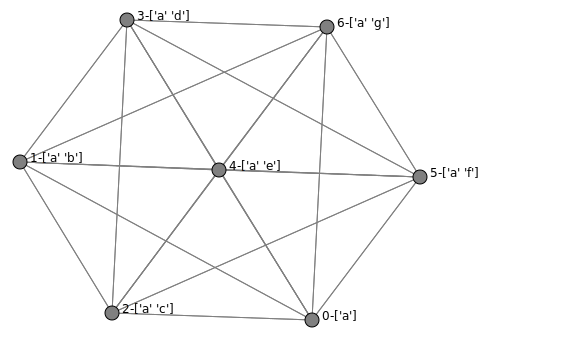

In [37]:
SVG(svg_graph(G6, names=[n + '-' + str(names_col6[x.indices]) for n, x in zip(names6, X6)]))

In [38]:
%%time
result, sorted_names_col = run_algorithm(G6, X6, names_col6, 1, 1000, 'log_custom6_bis')

['b' 'c' 'd' 'e' 'f' 'g' 'a']
CPU times: user 5.28 ms, sys: 1.75 ms, total: 7.03 ms
Wall time: 5.9 ms


In [39]:
for c in result:
    print(c[0], sorted_names_col[c[1]])

[0 1 2 3 4 5 6] ['a']
[1] ['b']
[2] ['c']
[3] ['d']
[4] ['e']
[5] ['f']
[6] ['g']


* pros:
    - pas de concept avec tous les noeuds malgré la densité  
* cons:
    - perte d'information sur la structure du graphe initial ? 

### Custom7  

1 article between 1 strong community and one diverse community

In [147]:
G7 = sparse.csr_matrix(np.array([
    [0, 1, 1, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 1, 1, 1, 0]
]))
X7 = sparse.csr_matrix(np.array([
    [1, 1, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 0, 0, 1, 0, 0],
    [0, 1, 1, 0, 0, 0],
    [0, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1]
]))
names7 = np.array(range(G7.shape[0])).astype(str)
names_col7 = np.array(['a', 'b', 'c', 'd', 'e', 'f'])

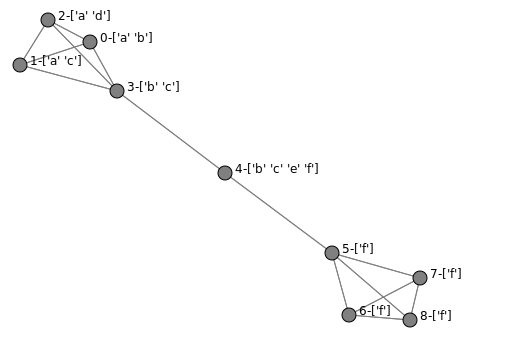

In [148]:
SVG(svg_graph(G7, names=[n + '-' + str(names_col7[x.indices]) for n, x in zip(names7, X7)]))

In [149]:
%%time
result, sorted_names_col = run_algorithm(G7, X7, names_col7, 1, 1000, 'log_custom7')

CPU times: user 14.3 ms, sys: 3.13 ms, total: 17.5 ms
Wall time: 15.3 ms


In [150]:
for c in result:
    print(c[0], sorted_names_col[c[1]])

[0 1 2 3 4 5 6 7 8] []
[2] ['d']
[4] ['e']
[0 1 2] ['a']
[0] ['a' 'b']
[1] ['a' 'c']
[0 3 4] ['b']
[3 4] ['b' 'c']
[1 3 4] ['c']
[4 5 6 7 8] ['f']


* pros:
    - `4` n'est pas isolé de `[5, 6, 7, 8]`
    - `2` isolé (seul qui contient `'d'`)
    - `4` isolé (seul qui contient `'e'`)
* cons: 
    - `[3, 4]` n'est pas nécessaire si on a `[1, 3, 4]` et `[0, 3, 4]` ?
    - 

In [190]:
def get_summarized_graph(adjacency, concepts):
    """Get summarized graph given concepts and original adjacency matrix."""
    
    rows, cols = [], []

    for c in concepts:

        # exclude first element of lattice 
        if len(c[1]) > 0:
            nodes = sorted(c[0])
            idx = 0
            idx_nodes = np.array([-1] * len(nodes)) # number of unique nodes from concepts
            # reindex nodes
            for n in nodes:
                if n not in idx_nodes:
                    idx_nodes[idx] = n
                    idx += 1
            
            # Record edges from subgraph related to concept
            adj_concept = adjacency[nodes, :][:, nodes].tocoo()
            reindex_rows = [int(idx_nodes[src]) for src in adj_concept.row]
            reindex_cols = [int(idx_nodes[dst]) for dst in adj_concept.col]
            rows += reindex_rows
            cols += reindex_cols
            
    return sparse.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=adjacency.shape).tocsr()

In [191]:
get_summarized_graph(G7, result)

<9x9 sparse matrix of type '<class 'numpy.float64'>'
	with 26 stored elements in Compressed Sparse Row format>

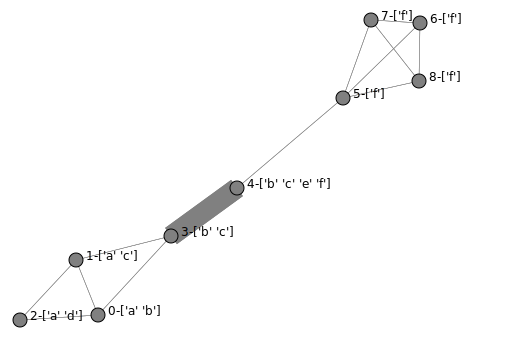

In [192]:
# Summarized graph
SVG(svg_graph(get_summarized_graph(G7, result), names=[n + '-' + str(names_col7[x.indices]) for n, x in zip(names7, X7)]))

### Custom8  

Connected common nodes one different node.

In [185]:
G8 = sparse.csr_matrix(np.array([
    [0, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 1, 1, 1, 1],
    [1, 1, 0, 1, 1, 1, 1],
    [1, 1, 1, 0, 1, 1, 1],
    [1, 1, 1, 1, 0, 1, 1],
    [1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 0]
]))
X8 = sparse.csr_matrix(np.array([
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 0, 0, 1, 1, 1],
]))
names8 = np.array(range(G8.shape[0])).astype(str)
names_col8 = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g'])

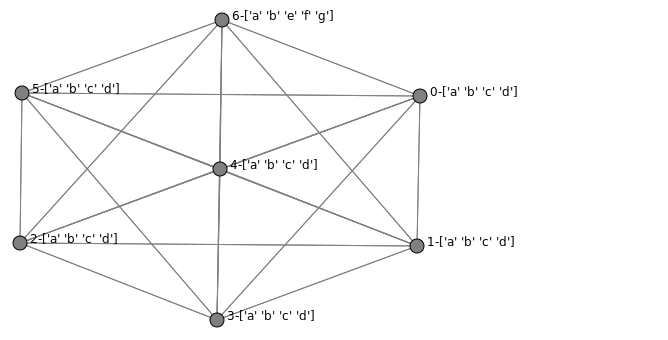

In [186]:
SVG(svg_graph(G8, names=[n + '-' + str(names_col8[x.indices]) for n, x in zip(names8, X8)]))

In [187]:
%%time
result, sorted_names_col = run_algorithm(G8, X8, names_col8, 1, 1000, 'log_custom8')

['e' 'f' 'g' 'c' 'd' 'a' 'b']
CPU times: user 12.7 ms, sys: 5.99 ms, total: 18.7 ms
Wall time: 32 ms


In [188]:
for c in result:
    print(c[0], sorted_names_col[c[1]])

[0 1 2 3 4 5 6] ['a' 'b']
[6] ['e' 'f' 'g' 'a' 'b']
[6] ['f' 'g' 'a' 'b']
[6] ['g' 'a' 'b']
[0 1 2 3 4 5] ['c' 'd' 'a' 'b']
[0 1 2 3 4 5] ['d' 'a' 'b']


* pros:
    - concept `6` avec attributs `['e', 'f', 'g']` $\rightarrow$ le graphe ne change pas mais on continue d'ajouter des attributs qui rendent le concept un peu plus intéressant, vu le faible nombre d'occurence de ces attributs dans le graphe initial. En revanche les attributs `'a'` et `'b'` n'apportent rien d'intéressant
    - pour le concept `[0, 1, 2, 3, 4, 5]`, l'attribut `'d'` n'apporte rien à `'c'` et inversement. Encore moins les attributs `['a', 'b']` qui sont trop fréquents
* cons:
    - le concept `[0, 1, 2, 3, 4, 5]` est divisé en 2
    - le concept `6` est divisé en 3

## Annexes

In [103]:
def init_inclose(context):
    extents, intents = [], []
    extents_init = np.arange(context.shape[0])
    intents_init = []
    extents.append(extents_init) # Initalize extents with all objects from context
    intents.append(intents_init) # Initialize intents with empty set attributes
    return extents, intents

def in_close_new(adjacency, context, extents, intents, r=0, y=0, min_support=0, max_support=np.inf, degs=[], unexs_g=[], 
                 unexs_a=[], unexs=[], names_col=[]):
    global r_new
    r_new = r_new + 1
    var = False
    
    print(f'NEW ITERATION \n --------')
    
    for j in np.arange(context.shape[1])[y:]:
        try:
            extents[r_new] = []
            unexs_g[r_new] = 0
            unexs_a[r_new] = 0
            unexs[r_new] = 0
        except IndexError:
            extents.append([])
            unexs_g.append(0)
            unexs_a.append(0)
            unexs.append(0)
            
        # Form a new extent by adding extension of attribute j to current concept extent
        ext_j = set(extension([j], context))
        extents[r_new] = list(sorted(set(extents[r]).intersection(ext_j)))
        len_new_extent = len(extents[r_new])
        
        print(f'extents: {extents[r]} - intents: {names_col[intents[r]]}')
        print(f'  Candidate attr: {names_col[j]}')
        print(f'  new extent: {extents[r_new]}')
        
        if (len_new_extent > min_support) and (len_new_extent < max_support):
                       
            if len_new_extent == len(extents[r]):
                print(f'  Extent size did not change -> attribute {names_col[j]} is added to intent.')
                intents[r] = list(sorted(set(intents[r]).union(set([j]))))
                var = True
            else:
                print(f'  Extent size DID change. IsCannonical: {is_cannonical(context, extents, intents, r, j - 1)}')
                
                if is_cannonical(context, extents, intents, r, j - 1):
                    print(f'   New branch will be created, compute U of current concept.')
                    try:
                        intents[r_new] = []
                    except IndexError:
                        intents.append([])
                    
                    intents[r_new] = list(sorted(set(intents[r]).union(set([j]))))
                    len_new_intent = len(intents[r_new])
                    print(f'  Intent: {names_col[intents[r_new]]}')
                    print(f'  --> Enter recursion...')

                    # ------------------------------------------------
                    # Compute difference between concepts unexpectedness
                    u_diff = unexs[r_new-1] - unexs[r-1]
                    print(f'  U difference; {u_diff}')
                    if r > 0 and r_new > 1 and u_diff < 0:
                        break
                    # ------------------------------------------------
                    
                    print(f'      **Unexpectedness: {unexs}')
                    in_close_new(adjacency, context, extents, intents, r=r_new, y=j+1, degs=degs, unexs_g=unexs_g, 
                                 unexs_a=unexs_a, unexs=unexs, names_col=names_col)

    
    
        if (unexs[r] == 0 and r != 0 and len(extents[r_new])>0) or var:
            print(f'ELSE r: {r} - r_new: {r_new}')
            print(f'Unexs: {unexs}')
            # ------------------------------------------------
            print(extents, intents)
            print(f'extents[r_new]: {extents[r_new]} - intents[r]: {names_col[intents[r]]}')
            # Graph unexpectedness 
            g_r = adjacency[extents[r_new]][:, extents[r_new]]
            complexity_desc_g = mdl_graph(g_r)
            complexity_gen_g = np.mean(complexity_gen_graphs.get(len(extents[r_new])))
            unex_g = complexity_gen_g - complexity_desc_g
            unexs_g[r] = unex_g
            print(f'  U(G): {unex_g}')

            # Attributes unexpectedness
            complexity_gen_a = np.log2(special.comb(context.shape[1], len(intents[r])))
            complexity_desc_a = 0
            for a in intents[r]:
                complexity_desc_a += np.log2(degs[a])

            unex_a = complexity_gen_a - complexity_desc_a
            unexs_a[r] = unex_a
            print(f'  U(A): {unex_a}')

            # Total unexpectedness
            unex = unex_g + unex_a
            unexs[r] = unex
            print(f'  U: {unex}')
            print(f'Unexs: {unexs}')
            # ------------------------------------------------
        var=False
        u_diff = unexs[r] - unexs[r-1]
        print(f'r: {r} - r_new: {r_new}')
        print(f'  U difference; {u_diff}')
        if r > 0 and r_new > 1 and u_diff < 0:
            extents[r] = []
            intents[r] = []
            break
    
    if (unexs[r] == 0 and r != 0 and len(extents[r])>0) or var:
        print(f'ELSE r: {r} - r_new: {r_new}')
        print(f'Unexs: {unexs}')
        # ------------------------------------------------
        print(extents, intents)
        print(f'extents[r_new]: {extents[r]} - intents[r]: {names_col[intents[r]]}')
        # Graph unexpectedness 
        g_r = adjacency[extents[r]][:, extents[r]]
        complexity_desc_g = mdl_graph(g_r)
        complexity_gen_g = np.mean(complexity_gen_graphs.get(len(extents[r])))
        unex_g = complexity_gen_g - complexity_desc_g
        unexs_g[r] = unex_g
        print(f'  U(G): {unex_g}')

        # Attributes unexpectedness
        complexity_gen_a = np.log2(special.comb(context.shape[1], len(intents[r])))
        complexity_desc_a = 0
        for a in intents[r]:
            complexity_desc_a += np.log2(degs[a])

        unex_a = complexity_gen_a - complexity_desc_a
        unexs_a[r] = unex_a
        print(f'  U(A): {unex_a}')

        # Total unexpectedness
        unex = unex_g + unex_a
        unexs[r] = unex
        print(f'  U: {unex}')
        print(f'Unexs: {unexs}')
        # ------------------------------------------------
    
    
    print(f'**END FUNCTION')
    print(f'**concept: ({[*zip(extents, intents)]})')
    
    return [*zip(extents, intents)]

In [ ]:
def init_inclose(context):
    extents, intents = [], []
    extents_init = np.arange(context.shape[0])
    intents_init = []
    extents.append(extents_init) # Initalize extents with all objects from context
    intents.append(intents_init) # Initialize intents with empty set attributes
    return extents, intents

def in_close_new(adjacency, context, extents, intents, r=0, y=0, min_support=0, max_support=np.inf, degs=[], unexs_g=[], unexs_a=[], unexs=[], names_col=[]):
    global r_new
    r_new = r_new + 1
    
    print(f'NEW ITERATION \n --------')
    print(f'r: {r} - r_new: {r_new}')
    # ------------------------------------------------
    print(f'|extents[r]|: {len(extents[r])} - intents[r]: {names_col[intents[r]]}')
    
    if len(extents[r]) < 1000:
        # Graph unexpectedness 
        unex_g = graph_unexpectedness(adjacency[extents[r], :][:, extents[r]], complexity_gen_graphs)
        unexs_g[r] = unex_g
        # Attributes unexpectedness
        unex_a = attr_unexpectedness(context, intents[r], degs)
        unexs_a[r] = unex_a
        # Total unexpectedness
        unex = unex_g + unex_a
        unexs[r] = unex
        print(f'  U(G): {unex_g}')
        print(f'  U(A): {unex_a}')
        print(f'  U: {unex}')
        # ------------------------------------------------
    
    for j in np.arange(context.shape[1])[y:]:
        try:
            extents[r_new] = []
            unexs_g[r_new] = 0
            unexs_a[r_new] = 0
            unexs[r_new] = 0
        except IndexError:
            extents.append([])
            unexs_g.append(0)
            unexs_a.append(0)
            unexs.append(0)
            
        # Form a new extent by adding extension of attribute j to current concept extent
        ext_j = set(extension([j], context))
        extents[r_new] = list(sorted(set(extents[r]).intersection(ext_j)))
        len_new_extent = len(extents[r_new])
        
        print(f'|extents|: {len(extents[r])} - intents: {names_col[intents[r]]}')
        print(f'  Candidate attr: {names_col[j]} - ({j})')
        print(f'  new extent: {extents[r_new]}')
        
        if (len_new_extent > min_support) and (len_new_extent < max_support):
                        
            unex_g = graph_unexpectedness(adjacency[extents[r_new], :][:, extents[r_new]], complexity_gen_graphs)
            unexs_g[r_new] = unex_g
            # Attributes unexpectedness
            unex_a = attr_unexpectedness(context, intents[r_new], degs)
            unexs_a[r_new] = unex_a
            # Total unexpectedness
            unex = unex_g + unex_a
            unexs[r_new] = unex
            print(f'  U(G): {unex_g}')
            print(f'  U(A): {unex_a}')
            print(f'  U: {unex}')
            print(f'unexs: {unexs} r_new: {r_new} - r: {r}')
            if (unexs[r_new] - unexs[r_new-1] > 0):
                       
                if len_new_extent == len(extents[r]):
                    print(f'  Extent size did not change -> attribute {names_col[j]} is added to intent.')
                    intents[r] = list(sorted(set(intents[r]).union(set([j]))))
                else:
                    print(f'  Extent size DID change. IsCannonical: {is_cannonical(context, extents, intents, r, j - 1)}')
                    if is_cannonical(context, extents, intents, r, j - 1):
                        try:
                            intents[r_new] = []
                        except IndexError:
                            intents.append([])

                        intents[r_new] = list(sorted(set(intents[r]).union(set([j]))))
                        len_new_intent = len(intents[r_new])
                        print(f'  --> Enter recursion with Intent: {names_col[intents[r_new]]}...')
                        in_close_new(adjacency, context, extents, intents, r=r_new, y=j+1, min_support=min_support, max_support=max_support, 
                                     degs=degs, unexs_g=unexs_g, unexs_a=unexs_a, unexs=unexs, names_col=names_col)

    print(f'**END FUNCTION')
    print(f'**concept: ({[*zip(extents, intents)]})')
    
    return [*zip(extents, intents)]

## Work on algorithm  

1. **InClose** without **IsCannonical** and with modified version of graph compressor (using only number of nodes)  
2. **InClose** with **IsCannonical** and with modified version of graph compressor (using only number of nodes)

In [641]:
def plot_distrib(values, ax, xlabel='degree', log=True, title=None, color='blue', alpha=1, label='Degree distribution'):
    counter = Counter(values)
    x, y = zip(*counter.items())
    ax.scatter(x, y, marker='+', color=color, alpha=alpha, label=label)
    ax.legend()
    ax.set_title(title)
    if log:
        ax.set_xscale('log')
        ax.set_xlabel(xlabel + ' (log)')
    else:
        ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency' + ' (log)')
    ax.set_yscale('log')
    
def mdl_graph(adjacency):
    n = adjacency.shape[0]

    # density
    #d = np.sum(adjacency) / (n * (n - 1))
    
    # nodes
    nodes_mdl = np.log2(n)
    
    # edges
    degrees = adjacency.dot(np.ones(n))
    max_degree = np.max(degrees)
    edges_mdl = (n + 1) * np.log2(max_degree + 1) + np.sum([np.log2(special.comb(n, deg)) for deg in degrees])

    if n == 1:
        return 1
    else:
        return nodes_mdl #+ edges_mdl

def entropy(prob):
    return prob * -np.log2(prob)

def desc_complexity(attrs):
    if isinstance(attrs, int):
        attrs = [attrs]
    prob = 1
    for attr in attrs:
        prob *= degrees[attr] / np.sum(degrees)
    entr = entropy(prob)
    return generation_complexity(biadjacency.shape[1], len(attrs)) * entr

def expand_list(l, idx, item):
    """If l[idx] does not exists, expand l with item."""
    try:
        l[idx] = item
    except IndexError:
        extents.append(item)    
        
def is_cannonical(context, extents, intents, r, y):
    global r_new

    for k in range(len(intents[r])-1, -1, -1):
        for j in range(y, intents[r][k], -1):            
            for h in range(len(extents[r_new])):
                if context[extents[r_new][h], j] == 0:
                    h -= 1 # Necessary for next test in case last interaction of h for-loop returns False
                    break
            if h == len(extents[r_new]) - 1:
                return False
        y = intents[r][k] - 1

    for j in reversed(range(y, -1, -1)):
        for h in range(len(extents[r_new])):
            if context[extents[r_new][h], j] == 0:
                h -= 1 # Necessary for next test in case last interaction of h for-loop returns False
                break
        if h == len(extents[r_new]) - 1:
            return False
    
    return True

def intention(nodes, context):
    if len(nodes) == 0:
        return np.arange(0, context.shape[1])
    else:
        return context[nodes, :].indices
    
def extension(attributes, context):
    if len(attributes) == 0:
        return np.arange(0, context.shape[0])
    else:
        return context.tocsc()[:, attributes].indices

def graph_unexpectedness(adjacency, gen_complexities):
    n = adjacency.shape[0]
    complexity_desc_g = mdl_graph(adjacency)
    complexity_gen_g = np.mean(gen_complexities.get(n))
    return complexity_gen_g - complexity_desc_g

def attr_unexpectedness(biadjacency, attributes, degrees):
    complexity_gen_a = np.log2(special.comb(biadjacency.shape[1], len(attributes)))
    complexity_desc_a = 0
    for a in attributes:
        complexity_desc_a += np.log2(degrees[a])
    return complexity_gen_a - complexity_desc_a

def pattern_unexpectedness(adjacency, biadjacency, gen_complexities, attributes, degrees):
    u_g = graph_unexpectedness(adjacency, gen_complexities)
    u_a = attr_unexpectedness(biadjacency, attributes, degrees)
    return u_g + u_a

In [642]:
%%time

attrs_degrees = get_degrees(biadjacency, transpose=True) / sum(get_degrees(biadjacency, transpose=True))
attrs_indexes = np.arange(0, biadjacency.shape[1])

complexity_gen_graphs = defaultdict(list)

for num_n in range(1, 1000):
    for j in range(10):
        sel_attrs = np.random.choice(attrs_indexes, size=num_n, replace=False, p=attrs_degrees)
        sel_nodes = biadjacency.tocsc()[:, sel_attrs].indices
        
        #sel_g = adjacency[sel_nodes, :][:, sel_nodes]
        #mdl = mdl_graph(sel_g)
        
        # mdl is just the complexity of the number of nodes
        mdl = np.log2(len(sel_nodes))
        complexity_gen_graphs[num_n].append(mdl)

CPU times: user 4.43 s, sys: 116 ms, total: 4.55 s
Wall time: 4.57 s


### 1. version **without** $\texttt{IsCannonical}$

In [701]:
def init_inclose(context):
    extents, intents = [], []
    extents_init = np.arange(context.shape[0])
    intents_init = []
    extents.append(extents_init) # Initalize extents with all objects from context
    intents.append(intents_init) # Initialize intents with empty set attributes
    return extents, intents

def in_close_new(adjacency, context, extents, intents, r=0, y=0, min_support=0, max_support=np.inf, degs=[], unexs_g=[], unexs_a=[], unexs=[], names_col=[]):
    global r_new
    global ptr
    r_new = r_new + 1
    
    print(f'NEW ITERATION \n --------')
    print(f'r: {r} - r_new: {r_new}')
    # ------------------------------------------------
    print(f'|extents[r]|: {len(extents[r])} - intents[r]: {names_col[intents[r]]}')
    
    for j in np.arange(context.shape[1])[y:]:
        try:
            extents[r_new] = []
            unexs_g[r_new] = 0
            unexs_a[r_new] = 0
        except IndexError:
            extents.append([])
            unexs_g.append(0)
            unexs_a.append(0)

            # Form a new extent by adding extension of attribute j to current concept extent
        ext_j = set(extension([j], context))
        extents[r_new] = list(sorted(set(extents[r]).intersection(ext_j)))
        len_new_extent = len(extents[r_new])
        
        #print(f'|extents|: {len(extents[r])} - intents: {names_col[intents[r]]}')
        #print(f'  Candidate attr: {names_col[j]} - ({j})')
        #print(f'  new extent: {extents[r_new]}')
        
        if (len_new_extent >= min_support) and (len_new_extent <= max_support):
                       
            new_intent = list(sorted(set(intents[r]).union(set([j]))))
            
            #try:
            #    unexs[r_new] = 0
            #except IndexError:
            #    unexs.append(0)
            # ------------------------------------------------------------------------------------------------------------
            print(f'  Extent size {len(extents[r_new])} - intent {new_intent}')
            unex_g = graph_unexpectedness(adjacency[extents[r_new], :][:, extents[r_new]], complexity_gen_graphs)
            unexs_g[r_new] = unex_g
            # Attributes unexpectedness
            unex_a = attr_unexpectedness(context, new_intent, degs)
            unexs_a[r_new] = unex_a
            # Total unexpectedness
            unex = unex_g + unex_a
            #unexs[r_new] = unex
            print(f'  U(G): {unex_g}')
            print(f'  U(A): {unex_a}')
            print(f'  U: {unex}')
            print(f'unexs: {unexs} r_new: {r_new} - r: {r} - ptr: {ptr}')
            # ------------------------------------------------------------------------------------------------------------
            
            if len_new_extent - len(extents[r]) == 0:
                #print(f' == comparing unex={unex} and unexs[{r_new-1}]={unexs[r_new-1]}')
                print(f' == comparing unex={unex} and unexs[{ptr}]={unexs[ptr]}')
                #if unexs[r_new] - unexs[r_new-1] >= 0:
                #if unex - unexs[r_new-1] >= 0:
                if unex - unexs[ptr] >= 0:
                    print(f'  Extent size did not change -> attribute {names_col[j]} is added to intent.')
                    intents[r] = new_intent
                    unexs[-1] = unex
                else:
                    #print(f'STOP rec, unexpectedness difference is {unexs[r_new] - unexs[r_new-1]}')
                    print(f'STOP rec, unexpectedness difference is {unex - unexs[ptr]}')
                    #del unexs[-(len(intents[r])+1):]
                    extents.pop(-1)
                    intents.pop(-1)
                    #r_new -= 1
                    break
                
            else:
                print(f'  Extent size DID change. IsCannonical: {is_cannonical(context, extents, intents, r, j - 1)}')
                #if is_cannonical(context, extents, intents, r, j - 1):
                try:
                    intents[r_new] = []
                    #unexs[r_new] = 0
                except IndexError:
                    intents.append([])
                    #unexs.append(0)

                intents[r_new] = new_intent 
                len_new_intent = len(intents[r_new])

                print(f'r:{r} rnew:{r_new}')
                #print(f' ISCANNO comparing unex={unex} and unexs[{r}]=={unexs[r]}')
                print(f' ISCANNO comparing unex={unex} and unexs[{ptr}]=={unexs[ptr]}')
                if unex - unexs[ptr] >= 0 or r == 0:   
                    #unexs[r_new] = unex
                    unexs.append(unex)
                    ptr += 1
                    print(f'  --> Enter recursion with Intent: {names_col[intents[r_new]]}...')
                    in_close_new(adjacency, context, extents, intents, r=r_new, y=j+1, min_support=min_support, max_support=max_support, 
                                 degs=degs, unexs_g=unexs_g, unexs_a=unexs_a, unexs=unexs, names_col=names_col)
                    
    print(f'inexs: {unexs}')        
    print(f'r:{r} - r_new:{r_new}')
    unexs.pop(-1)
    ptr -= 1
    print(f'inexs after pop: {unexs}')        
    print(f'**END FUNCTION')
    print(f'**concept: ({[*zip(extents, intents)]})')
    
    return [*zip(extents, intents)]

In [702]:
adjacency = wikivitals.adjacency
biadjacency = wikivitals.biadjacency
names = wikivitals.names
words = wikivitals.names_col
labels = wikivitals.labels

# Initialization
extents, intents = init_inclose(biadjacency)
degs = get_degrees(biadjacency, transpose=True)
global r_new
r_new = 0
global ptr 
ptr = 0

# Degree of attribute = # articles in which it appears
freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
index = np.flatnonzero((freq_attribute <= 50) & (freq_attribute >= 10))

# Filter data with index
biadjacency = biadjacency[:, index]
words = words[index]
freq_attribute = freq_attribute[index]

# Order attributes according to their ascending degree
# This allows to add first attributes that will generate bigger subgraphs
sort_index = np.argsort(freq_attribute)
sorted_degs = freq_attribute[sort_index]
filt_biadjacency = biadjacency[:, sort_index]
sorted_names_col = words[sort_index]

In [703]:
filt_biadjacency

<4403x3811 sparse matrix of type '<class 'numpy.int64'>'
	with 81990 stored elements in Compressed Sparse Row format>

In [704]:
%%time

# Algorithm
with open('logs/log_new_algo', 'w') as f:
    with redirect_stdout(f):
        concepts = in_close_new(adjacency, filt_biadjacency, extents, intents, r=0, y=0, 
                                min_support=5, max_support=800,
                                degs=sorted_degs, unexs_g=[0], unexs_a=[0], unexs=[0], names_col=sorted_names_col)
        print()

# Save result
with open("result/result_new_algo.bin", "wb") as output:
    pickle.dump(result, output)
    
print(len(concepts))

10810
CPU times: user 49min 47s, sys: 50.3 s, total: 50min 37s
Wall time: 50min 48s


In [705]:
print(f'Number of results : {len(concepts)}')

Number of results : 10810


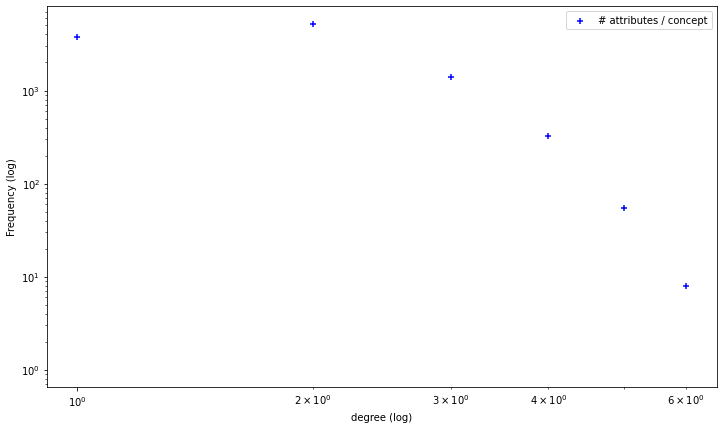

In [706]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
plot_distrib([len(x[1]) for x in concepts], ax=ax, log=True, label='# attributes / concept')

In [748]:
concepts_5size = [x for x in concepts if len(x[1]) > 5]

[428, 642, 644, 660, 2516] [187, 1184, 1569, 2333, 2848, 3436]
['taíno' 'hispaniola' 'haiti' 'dominican' 'columbu' 'cuba']


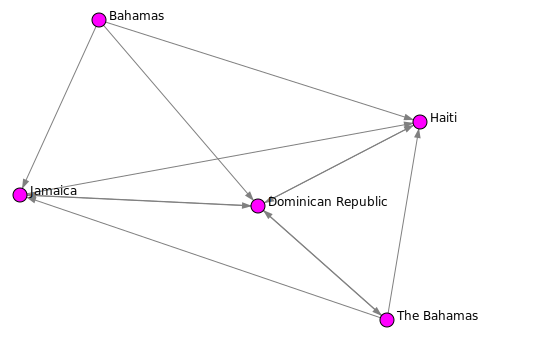

In [749]:
rand_idx = np.random.choice(len(concepts_5size), 1)
concept = concepts_5size[rand_idx[0]]
objs, attrs = concept

print(objs, attrs)
print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))
image = svg_graph(image_adj, names=names[objs], labels=labels[objs])

SVG(image)

[171, 195, 341, 494, 516, 528, 551, 598, 740, 882, 908, 1013, 1079, 1144, 1315, 1331, 1415, 1445, 1629, 1734, 1767, 2071, 2072, 2149, 2572, 3266, 3336, 3487, 3565, 3687, 3741, 4251] [3094]
['adher']


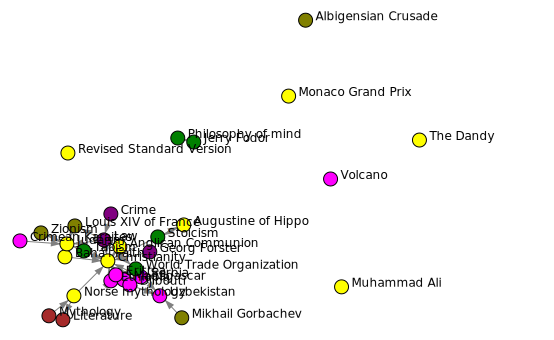

In [736]:
rand_idx = np.random.choice(len(concepts), 1)
concept = concepts[rand_idx[0]]
objs, attrs = concept

print(objs, attrs)
print(sorted_names_col[attrs])

image_adj = adjacency[objs, :][:, objs]
if image_adj.nnz == 0:
    image_adj += sparse.diags(np.ones(len(objs)))
image = svg_graph(image_adj, names=names[objs], labels=labels[objs])

SVG(image)

In [737]:
def get_summarized_graph(adjacency, concepts):
    """Get summarized graph given concepts and original adjacency matrix."""
    
    rows, cols = [], []

    for c in concepts:

        # exclude first element of lattice 
        if len(c[1]) > 0:
            nodes = sorted(c[0])
            idx = 0
            idx_nodes = np.array([-1] * len(nodes)) # number of unique nodes from concepts
            # reindex nodes
            for n in nodes:
                if n not in idx_nodes:
                    idx_nodes[idx] = n
                    idx += 1
            
            # Record edges from subgraph related to concept
            adj_concept = adjacency[nodes, :][:, nodes].tocoo()
            reindex_rows = [int(idx_nodes[src]) for src in adj_concept.row]
            reindex_cols = [int(idx_nodes[dst]) for dst in adj_concept.col]
            rows += reindex_rows
            cols += reindex_cols
            
    return sparse.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=adjacency.shape).tocsr()

In [741]:
summarized_adj = get_summarized_graph(adjacency, concepts)
summarized_adj

<4403x4403 sparse matrix of type '<class 'numpy.float64'>'
	with 46782 stored elements in Compressed Sparse Row format>

In [744]:
len(Counter(get_connected_components(adjacency)))

1

In [739]:
labels_cc_summarized = get_connected_components(summarized_adj)
len(Counter(labels_cc_summarized))

139

In [747]:
# Number of nodes in the largest connected component of summarized graph
Counter(labels_cc_summarized)[0]

4265

$\rightarrow$ problem: Only one big connecected component out of 139  


We can try to merge concepts with at least $k$ attributes.

In [771]:
# Summarized graph with concepts containing at least k attributes
k = 3
summarized_adj = get_summarized_graph(adjacency, [x for x in concepts if len(x[1]) >= k])
summarized_adj

<4403x4403 sparse matrix of type '<class 'numpy.float64'>'
	with 4619 stored elements in Compressed Sparse Row format>

In [772]:
labels_cc_summarized = get_connected_components(summarized_adj)
print(len(Counter(labels_cc_summarized)))
print(sorted(dict(Counter(labels_cc_summarized)).items(), key=lambda x: x[1], reverse=True)[0])

3180
(7, 821)


In [773]:
# Number of cc with more than 1 node in it
len([x for x in sorted(dict(Counter(labels_cc_summarized)).items(), key=lambda x: x[1], reverse=True) if x[1] > 1])

56

In [775]:
mask = get_degrees(summarized_adj) > 1

# Find random connected component in summarized graph
idx = np.random.choice(labels_cc_summarized[mask])
mask_cc = labels_cc_summarized == idx
g_cc = summarized_adj[mask_cc, :][:, mask_cc]

# Related concepts
concepts = []
g_cc_nodes = mask[mask_cc]

for c in concepts:
    if len(c[1]) > 1:
        for x in c[0]:
            if x in g_cc_nodes:
                concepts.append(c)
                break
                
print(f'Number of concepts related to connected component: {len(concepts)}')
print()

# Print related concepts
for c in concepts[:10]:
    print(f'{(str(names[c[0]]))} - {(str(sorted_names_col[c[1]]))}')
    print()
    
image = svg_graph(g_cc, names=names[mask_cc], labels=labels[mask_cc], edge_width_min=0.5, edge_width_max=0.5, width=400, height=400)
SVG(image)

NameError: name 'mask' is not defined

### 1. version **with** $\texttt{IsCannonical}$